In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl

In [15]:
SAVEDIR = "/workspace/mnt/local/data/pgurevich/magnitude"
datapath_magn = f"{SAVEDIR}/clf_results_magnitude_final.pkl"
datapath_embs = f"{SAVEDIR}/clf_results_embeddings_final.pkl"
datapath_both = f"{SAVEDIR}/clf_results_both_final.pkl"

with open(datapath_magn, 'rb') as f:
    results_magn = pkl.load(f)

with open(datapath_embs, 'rb') as f:
    results_embs = pkl.load(f)

with open(datapath_both, 'rb') as f:
    results_both = pkl.load(f)

In [17]:
aucs_magn = results_magn['aucs']
mistakes_magn = results_magn['mistakes']

aucs_embs = results_embs['aucs']
mistakes_embs = results_embs['mistakes']

aucs_both = results_both['aucs']
mistakes_both = results_both['mistakes']

aucs_magn, aucs_embs, aucs_both

([np.float64(0.9154074703864223)],
 [np.float64(0.996293262551065)],
 [np.float64(0.9964847917199492)])

(145.0, 322.0)

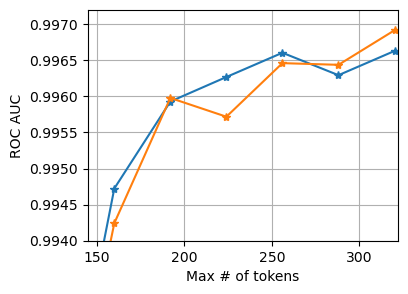

In [13]:
max_lengths = list(range(64, 321, 32))
plt.figure(figsize=(4, 3))
plt.plot(max_lengths, aucs_embs, marker='*')
plt.plot(max_lengths, aucs_both, marker='*')
plt.xlabel("Max # of tokens")
plt.ylabel("ROC AUC")
plt.grid()
plt.ylim(0.994, 0.9972)
plt.xlim(145, 32)

In [5]:
DATA_PATH = "/workspace/mnt/local/data/pgurevich/magnitude/small_data.csv"
data = pd.read_csv(DATA_PATH)
data

,text,label,prompt_name,source,RDizzl3_seven
0,"Hey there! \n\nSo, you know how sometimes you'...",1,Seeking multiple opinions,llama2_chat,False
1,\nThe Face on Mars is Merely a Natural Landfor...,1,The Face on Mars,darragh_claude_v6,True
2,I disagree with the principal's decision to re...,1,Mandatory extracurricular activities,darragh_claude_v7,False
3,**The Seagoing Cowboys: An Adventure of a Life...,1,"""A Cowboy Who Rode the Waves""",palm-text-bison1,True
4,Schools that offer distance learning is a open...,0,Distance learning,persuade_corpus,False
...,...,...,...,...,...
995,"Venus is considered as Earth's twin, so why no...",0,Exploring Venus,persuade_corpus,True
996,"Dear Senator,\n\nIts official, the electoral c...",0,Does the electoral college work?,persuade_corpus,True
997,Taking time to consider a career before enteri...,1,Seeking multiple opinions,mistral7binstruct_v1,False
998,Schools always want what is best for their stu...,0,Summer projects,persuade_corpus,False


In [6]:
data.source.value_counts().loc['llama2_chat']

np.int64(65)

In [7]:
from collections import defaultdict as ddict

mistakes_list = dict()
names_set = set()

for i, m in enumerate(mistakes):
    for key, val in m.items():
        names_set.add(key)
        if key not in mistakes_list.keys():
            mistakes_list[key] = np.zeros(len(max_lengths))
        mistakes_list[key][i] = val

for m in mistakes:
    for name in names_set:
        if name not in m.keys():
            m[name] = 0


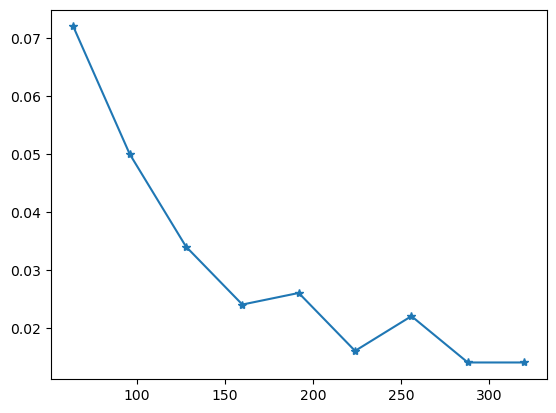

In [8]:
mean_misclass = np.zeros(len(max_lengths))
for val in mistakes_list.values():
    mean_misclass += val
mean_misclass /= 500


plt.plot(max_lengths, mean_misclass, marker='*')

/tmp/ipykernel_2227049/507992671.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(ncols=2);


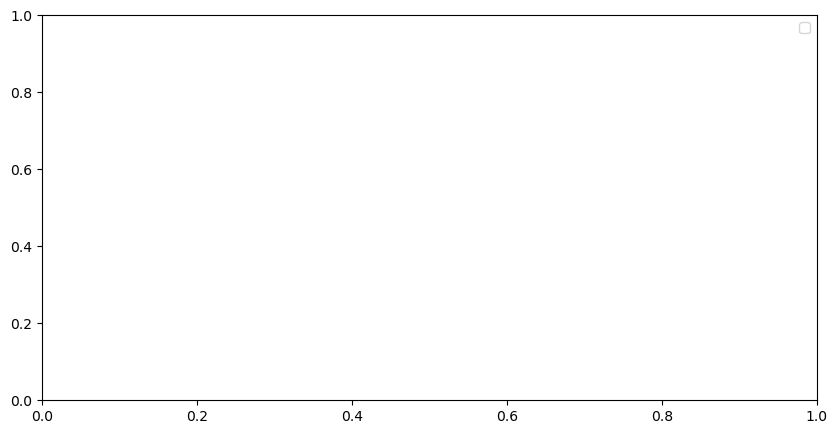

In [10]:
plt.figure(figsize=(10, 5))

for key, val in mistakes_list.items():
    val = val.astype(np.float32)
    num = data.source.value_counts().loc[key].astype(np.float32)
    val /= num
    # if 0 not in val and val.max() > 0.34:
    #     plt.plot(max_lengths, val, label=key)

plt.legend(ncols=2);

In [11]:
def bar_mistakes(mistakes, i, data, inds):
    names, vals = mistakes[i].keys(), mistakes[i].values()
    vals = np.array(list(vals)).astype(np.float32)
    nums = np.array([data.source.value_counts().loc[x] for x in names]).astype(np.float32)
    vals /= nums
    names = np.array(list(names))
    plt.barh(names[inds], vals[inds], alpha=0.4)

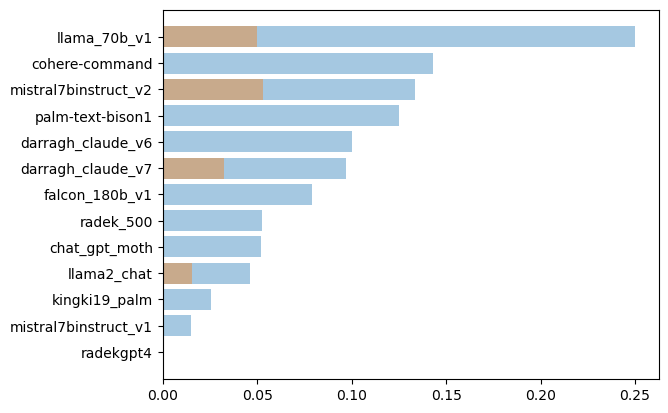

In [12]:
vals = np.array(list(mistakes[0].values())).astype(np.float32)
nums = np.array([data.source.value_counts().loc[x] for x in mistakes[0].keys()]).astype(np.float32)
vals /= nums
inds = np.argsort(vals)

bar_mistakes(mistakes, 0, data, inds)
bar_mistakes(mistakes, -1, data, inds)

In [23]:
vals[inds]

array([0.        , 0.        , 0.        , 0.        , 0.10666667,
       0.15384616, 0.16666667, 0.16666667, 0.24675325, 0.25      ,
       0.2857143 , 0.2857143 , 0.28947368, 0.29032257, 0.3       ],
      dtype=float32)

<BarContainer object of 12 artists>

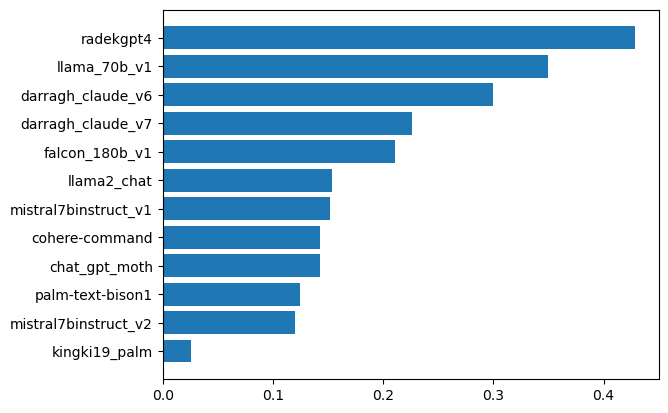

In [71]:
data.source.value_counts()

source
persuade_corpus                       475
chat_gpt_moth                          77
mistral7binstruct_v2                   75
mistral7binstruct_v1                   66
llama2_chat                            65
kingki19_palm                          39
falcon_180b_v1                         38
darragh_claude_v7                      31
darragh_claude_v6                      30
train_essays                           25
llama_70b_v1                           20
radek_500                              19
NousResearch/Llama-2-7b-chat-hf         9
mistralai/Mistral-7B-Instruct-v0.1      9
palm-text-bison1                        8
radekgpt4                               7
cohere-command                          7
Name: count, dtype: int64